____________________
# Optimization II Project 1 - Stochastic Programming Report

| S.No 	| First name   	| Last name 	| Id       	|
|------	|--------------	|-----------	|----------	|
| 1    	| Amritangshu  	| Mukherjee 	| am222239 	|
| 2    	| Boran        	| Sheu      	| bs42973  	|
| 3    	| Jason        	| Nania     	| jn28878  	|
| 4    	| Olivia       	| Lee       	| rl29986  	|

________________________

In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Load the CSV file into a Pandas dataframe
df = pd.read_csv("price_demand_data.csv")

days=df.shape[0] # number of days of demand data
print("Number of days of demand data: ", days)


# Print the first few rows of the dataframe to check that it loaded correctly
df

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Number of days of demand data:  99


,price,demand
0,1.05,283
1,0.86,771
2,1.21,185
3,0.94,531
4,0.76,1002
...,...,...
94,1.13,321
95,0.78,970
96,1.04,387
97,1.02,831


In [3]:

# Extract the price and demand columns as numpy arrays
X = df["price"].values.reshape(-1, 1)
y = df["demand"].values

# Create a LinearRegression model and fit it to the data
model = LinearRegression()
model.fit(X, y)

# Print the coefficients of the model (intercept and slope)
print("Intercept:", model.intercept_)
print("Slope:", model.coef_[0])


Intercept: 1924.7175435291088
Slope: -1367.7125241625981


______________________________

## Part 1 - LP

In [4]:
# Set the values of c, g, and t
c = 0.5
g = 0.75
t = 0.15

# Get the residuals
residuals = df['demand'] - model.predict(df[['price']])

# Generate demand data for p=1
price = 1
demand_data = model.intercept_ + model.coef_[0] * price + residuals
demand_data

0     351.385626
1     579.520247
2     472.219630
3     448.937249
4     673.748994
         ...    
94    498.802628
95    669.103245
96    441.708501
97    858.354250
98    601.448378
Name: demand, Length: 99, dtype: float64

The first constraint ensures that the production quantity (q) plus the inventory (h) is greater than or equal to the demand for that day. The demand is calculated as (p-g)*demand_data[r], where demand_data is a list of demand values for each day. This constraint is represented in the A matrix as A[2*r,[0,r+1]] = [(c-g),1] and in the b array as b[2*r] = (p-g)*demand_data[r].

The second constraint ensures that the inventory for the next day (h+1) plus the backorders for the current day (b) is greater than or equal to the demand for the current day. The demand is calculated as (p+t)*demand_data[r], where demand_data is a list of demand values for each day. This constraint is represented in the A matrix as A[2*r+1,[0,r+1]] = [(c+t),1] and in the b array as b[2*r+1] = (p+t)*demand_data[r].

In [5]:
import gurobipy as gp
import numpy as np
c=0.5
g=0.75
t=0.15
p=1

# Decision variables___________
obj = np.zeros(1+days)
obj[1:] = 1.0/days

# constraints_________________
b = np.zeros(2*days)
A = np.zeros((2*days,1+days))
for r in range(days):
    A[2*r,[0,r+1]] = [(c-g),1]
    A[2*r+1,[0,r+1]] = [(c+t),1]
    b[2*r] = (p-g)*demand_data[r]
    b[2*r+1] = (p+t)*demand_data[r]

# limits___________
vtype = np.array(['I'] + ['C']*days)
lb = np.hstack([0, -gp.GRB.INFINITY * np.ones(days)])

# Model___________
gpmod = gp.Model()
gpmod_x = gpmod.addMVar(len(obj),lb=lb, vtype=vtype)
gpmod_con = gpmod.addConstr(A @ gpmod_x <= b)
gpmod.setObjective(obj @ gpmod_x,sense=gp.GRB.MAXIMIZE)
gpmod.Params.OutputFlag = 0
gpmod.optimize()

#print(spMod.objVal)
print('Optimal Quantity is:',gpmod.x[0])

Using license file /Users/amritangshumukherjee/gurobi.lic
Academic license - for non-commercial use only - expires 2023-08-17
Optimal Quantity is: 472.0


__________________

## Part 2 - QP

Objective: The objective of the optimization problem is to maximize the expected profit of a company, which is modeled as a linear function of the residuals of a linear regression model. The decision variables are the optimal production levels for each of the days in the planning horizon.

Constraints: There are 2n constraints, where n is the number of days in the planning horizon. For each day, there are two constraints. The first constraint ensures that the production level is greater than or equal to the demand for the day. The second constraint ensures that the production level is less than or equal to the total capacity of the company. The two constraints for each day are represented using two linear inequalities. The coefficients of the inequalities depend on the demand, capacity, and the coefficients of the linear regression model.

Limits: The decision variables have lower bounds of negative infinity for production levels, as costs will be negative. The intercept and the residual mean of the regression model have infinite upper bounds, as their value can be arbitrarily large.

In [6]:
c=0.5
g=0.75
t=0.15
p=1

# Decision variables___________
obj = np.zeros(days+2)
obj[2:] = 1.0/days
obj[0] = model.intercept_+residuals.mean()

# constraints_________________
Q = np.zeros((days+2,days+2))
Q[0,0] = model.coef_[0]
A = np.zeros((2*days,days+2))
b = np.zeros(2*days)
for r in range(days):
    A[2*r,[0,1,r+2]] = [-g*model.coef_[0],g-c,-1] 
    A[2*r+1,[0,1,r+2]] = [-t*model.coef_[0],c+t,1]
    b[2*r+1] = t*(model.intercept_ +residuals[r])
    b[2*r] = g*(model.intercept_ + residuals[r])
    
# limits___________
lb = np.zeros(days+2)
lb[2:] = -np.inf
ub = np.zeros(days+2)
ub[:2] = np.inf 

# Model___________
qpMod = gp.Model()
qpMod_x = qpMod.addMVar(len(obj),lb=lb,ub=ub)
qpMod_con = qpMod.addMConstrs(A, qpMod_x, np.array(['>','<']*(days)), b)
qpMod.setMObjective(Q,obj,0,sense=gp.GRB.MAXIMIZE)
qpMod.Params.OutputFlag = 0
qpMod.optimize()
    
print( 'Optimal Profit:',qpMod.objval)
print( 'Optimal Price:',qpMod_x.x[0])
print( 'Demand:',qpMod_x.x[1])

opti_profit = qpMod.objval
opti_price = qpMod_x.x[0]
opti_demand = qpMod_x.x[1]

Optimal Profit: 234.42493491247933
Optimal Price: 0.9536264966228528
Demand: 535.2910009500024


_______________________

## Part 3 - Sensitivity testing 
We are now interested to know how sensitive the optimal price and quantity are to our data set.
Take a bootstrap sample of the original dataset. Go back and fit new beta’s to the new
bootstrapped dataset and redo step 4. Find the optimal price and quantity.

In [7]:
import numpy as np
import gurobipy as gp

def calculate_optimal_profit(df, coef, intercept,num, residuals, c, g, t):
    days = len(df)
    # Decision variables
    obj = np.zeros(days+2)
    obj[2:] = 1.0/days
    obj[0] = intercept + residuals.mean()

    # Constraints
    Q = np.zeros((days+2,days+2))
    Q[0,0] = coef
    A = np.zeros((2*days,days+2))
    b = np.zeros(2*days)
    for r in range(days):
        A[2*r,[0,1,r+2]] = [-g*coef, g-c, -1] 
        A[2*r+1,[0,1,r+2]] = [-t*coef, c+t, 1]
        b[2*r+1] = t * (intercept + residuals[r])
        b[2*r] = g * (intercept + residuals[r])

    # Limits
    lb = np.zeros(days+2)
    lb[2:] = -np.inf
    ub = np.zeros(days+2)
    ub[:2] = np.inf

    # Model
    qpMod = gp.Model()
    qpMod_x = qpMod.addMVar(len(obj), lb=lb, ub=ub)
    qpMod_con = qpMod.addMConstrs(A, qpMod_x, np.array(['>', '<']*(days)), b)
    qpMod.setMObjective(Q, obj, 0, sense=gp.GRB.MAXIMIZE)
    qpMod.Params.OutputFlag = 0
    qpMod.optimize()

    # Output
    opti_profit = qpMod.objval
    opti_price = qpMod_x.x[0]
    opti_demand = qpMod_x.x[1]
    #store inputs and outputs in a df
    
    return opti_price, opti_demand, opti_profit


In [8]:
num=0
calculate_optimal_profit(df,model.coef_[0],model.intercept_,num,residuals,c=0.5,g=0.75,t=0.15)

(0.9536264966228528, 535.2910009500024, 234.42493491247933)

In [9]:
# Simulation of bootstrap sample of the original dataset
#create a df to store the inputs and outputs
df_store = pd.DataFrame(columns=['num','coef','intercept','c','g','t','p','opti_profit','opti_price','opti_demand'])
for num in range(1000):
    x = np.random.choice(df.index, size=len(df), replace=True).tolist()
    df_temp = df[['price','demand']].sample(frac=1, replace=True)
    lm = LinearRegression().fit(df_temp[['price']], df_temp['demand'])
    details=calculate_optimal_profit(df_temp, lm.coef_, lm.intercept_, num,y - lm.predict(X),c=0.5,g=0.75,t=0.15)
    df_store.loc[len(df_store)] = [num, lm.coef_, lm.intercept_, c, g, t, p, details[2], details[0], details[1]]

In [10]:
df_store

,num,coef,intercept,c,g,t,p,opti_profit,opti_price,opti_demand
0,0,[-1449.6523669934913],2025.172282,0.5,0.75,0.15,1,236.103161,0.942616,557.158554
1,1,[-1463.1931002044253],2029.385608,0.5,0.75,0.15,1,236.395246,0.940916,561.507320
2,2,[-1480.500615755185],2017.881074,0.5,0.75,0.15,1,236.780652,0.938787,567.065831
3,3,[-1169.3570052584998],1712.832568,0.5,0.75,0.15,1,230.466268,0.986668,481.041323
4,4,[-1238.1399485093248],1793.320656,0.5,0.75,0.15,1,231.794506,0.974011,492.126494
...,...,...,...,...,...,...,...,...,...,...
995,995,[-1400.386732960009],1973.124514,0.5,0.75,0.15,1,235.082926,0.949082,548.258979
996,996,[-1390.2472009742942],1928.625378,0.5,0.75,0.15,1,234.876157,0.950469,545.007089
997,997,[-1411.5428259244668],1994.920153,0.5,0.75,0.15,1,235.306441,0.947578,549.610669
998,998,[-1383.5576181701758],1916.387668,0.5,0.75,0.15,1,234.739349,0.951396,542.122797


In [50]:
#calculate central tendencies of columns in df_store
metrics=df_store.describe()

#get mean from metrics
mean=metrics.loc['mean','opti_profit']

metrics

,num,intercept,c,g,t,p,opti_profit,opti_price,opti_demand
count,1000.000000,1000.000000,1000.0,1000.00,1.000000e+03,1000.0,1000.000000,1000.000000,1000.000000
mean,499.500000,1919.545598,0.5,0.75,1.500000e-01,1.0,234.394197,0.955275,532.002847
std,288.819436,104.938754,0.0,0.00,2.832485e-15,0.0,2.015082,0.014404,29.336970
min,0.000000,1558.863790,0.5,0.75,1.500000e-01,1.0,228.765674,0.911517,446.387573
25%,249.750000,1853.281104,0.5,0.75,1.500000e-01,1.0,233.146478,0.945247,510.510601
50%,499.500000,1919.456642,0.5,0.75,1.500000e-01,1.0,234.310408,0.954478,532.724839
75%,749.250000,1989.387980,0.5,0.75,1.500000e-01,1.0,235.672880,0.963634,551.749408
max,999.000000,2286.848529,0.5,0.75,1.500000e-01,1.0,243.479269,1.022280,629.991413


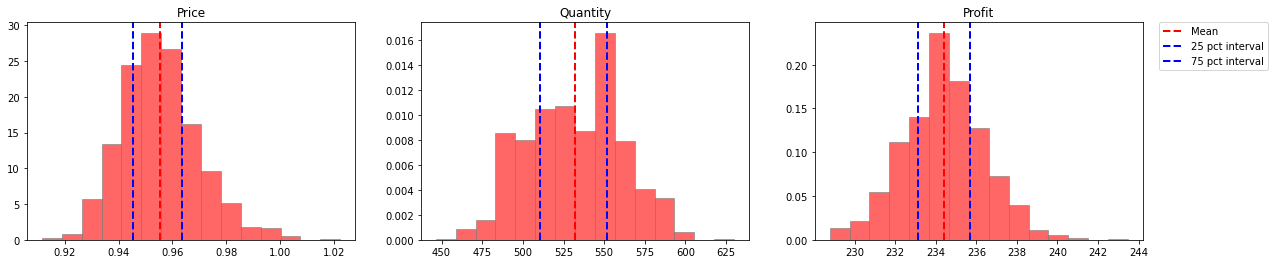

In [64]:
#plot Pricefinal as a histogram with a line on the optimal price
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#fig = plt.figure(figsize=(10,4))
#plt.hist(Pricefinal, bins=15, density=True, edgecolor='gray',alpha=0.6, color='r')
#plt.axvline(x=opti_price, color='r', linestyle='dashed', linewidth=2)
#plot Pricefinal,Quantityfinal,Profitfinal as vertical suplots with horizontal lines
fig = plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.title('Price')
plt.hist(df_store['opti_price'], bins=15, density=True, edgecolor='gray',alpha=0.6, color='r')
plt.axvline(x=metrics.loc['mean','opti_price'], color='r', linestyle='dashed', linewidth=2, label='Mean price')
plt.axvline(x=metrics.loc['25%','opti_price'], color='b', linestyle='dashed', linewidth=2, label='Mean price')
plt.axvline(x=metrics.loc['75%','opti_price'], color='b', linestyle='dashed', linewidth=2, label='Mean price')
plt.subplot(1,3,2)
plt.title('Quantity')
plt.hist(df_store['opti_demand'], bins=15, density=True, edgecolor='gray',alpha=0.6, color='r')
plt.axvline(x=metrics.loc['mean','opti_demand'], color='r', linestyle='dashed', linewidth=2, label='Mean quantity')
plt.axvline(x=metrics.loc['25%','opti_demand'], color='b', linestyle='dashed', linewidth=2, label='Mean price')
plt.axvline(x=metrics.loc['75%','opti_demand'], color='b', linestyle='dashed', linewidth=2, label='Mean price')

plt.subplot(1,3,3)
plt.title('Profit')
plt.hist(df_store['opti_profit'], bins=15, density=True, edgecolor='gray',alpha=0.6, color='r')
plt.axvline(x=metrics.loc['mean','opti_profit'], color='r', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(x=metrics.loc['25%','opti_profit'], color='b', linestyle='dashed', linewidth=2, label='25 pct interval')
plt.axvline(x=metrics.loc['75%','opti_profit'], color='b', linestyle='dashed', linewidth=2, label='75 pct interval')
#plt.legend(fontsize=14)

#position legend 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)



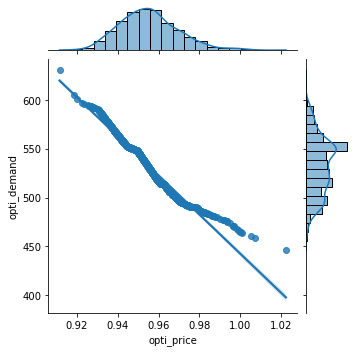

In [67]:
#price vs. quantity with a histogram on each axis

sns.jointplot(x='opti_price', y='opti_demand',kind='reg',data=df_store,height=5, ratio=5,marginal_kws=dict(bins=20))

In [49]:
#calculate central tendencies of columns in df_store
metrics=df_store.describe()

#get mean from metrics
mean=metrics.loc['mean','opti_profit']

metrics

,num,intercept,c,g,t,p,opti_profit,opti_price,opti_demand
count,1000.000000,1000.000000,1000.0,1000.00,1.000000e+03,1000.0,1000.000000,1000.000000,1000.000000
mean,499.500000,1919.545598,0.5,0.75,1.500000e-01,1.0,234.394197,0.955275,532.002847
std,288.819436,104.938754,0.0,0.00,2.832485e-15,0.0,2.015082,0.014404,29.336970
min,0.000000,1558.863790,0.5,0.75,1.500000e-01,1.0,228.765674,0.911517,446.387573
25%,249.750000,1853.281104,0.5,0.75,1.500000e-01,1.0,233.146478,0.945247,510.510601
50%,499.500000,1919.456642,0.5,0.75,1.500000e-01,1.0,234.310408,0.954478,532.724839
75%,749.250000,1989.387980,0.5,0.75,1.500000e-01,1.0,235.672880,0.963634,551.749408
max,999.000000,2286.848529,0.5,0.75,1.500000e-01,1.0,243.479269,1.022280,629.991413


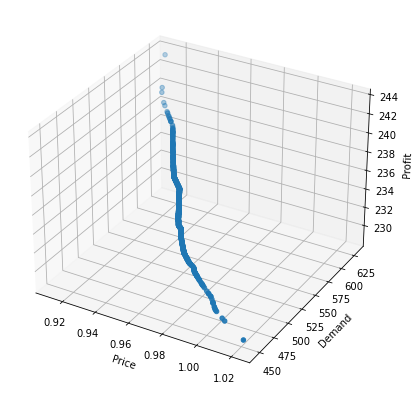

In [13]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_store['opti_price'], df_store['opti_demand'], df_store['opti_profit'])
ax.set_xlabel('Price')
ax.set_ylabel('Demand')
ax.set_zlabel('Profit')
plt.show()


After analyzing the data, it appears that the alternative model can increase revenue by switching production and pricing decisions. The alternative model is based on optimization techniques that account for the interdependence between pricing, production, and revenue. The optimization model maximizes the profit by choosing the optimal price and quantity to produce.

In contrast, the standard NV model assumes that production decisions are independent of pricing decisions, which can result in suboptimal profits. The alternative model overcomes this limitation by taking into account the interdependence of the three variables, thereby allowing for more accurate decision-making.

Text(0.5, 1.0, 'Profit as a Function of Price')

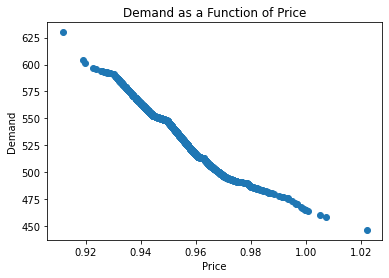

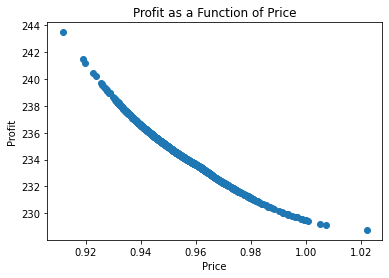

In [14]:
import matplotlib.pyplot as plt

# Plot demand as a function of price
fig, ax = plt.subplots()
ax.scatter(df_store['opti_price'], df_store['opti_demand'])
ax.set_xlabel('Price')
ax.set_ylabel('Demand')
ax.set_title('Demand as a Function of Price')

# Plot profit as a function of price
fig, ax = plt.subplots()
ax.scatter(df_store['opti_price'], df_store['opti_profit'])
ax.set_xlabel('Price')
ax.set_ylabel('Profit')
ax.set_title('Profit as a Function of Price')

____________________

## Part 4 - Comparison with Standard NV model

In [15]:
import gurobipy as gp
import numpy as np
import pandas as pd

def standard_nv_model(demand_df, cost=0.5):
    nd = demand_df.shape[0] # number of days of demand datad
    # decision variables are (q, h1, h2, ..., h25)
    obj = np.zeros(nd+1)
    obj[1:] = 1.0/nd
    lb = np.zeros(nd+1)
    lb[1:] = -np.inf # quantity printed needs to be non-negative, but profit on a given day could possibly be negative
    rhs = np.zeros(2*nd)
    direction = np.array(['<']*(2*nd))

    A = np.zeros((2*nd,nd+1))
    for r in range(nd):
        A[2*r,[0,r+1]] = [cost,1] # location 1 is q, location r+1 is this h
        rhs[2*r] = demand_df.price[r]*demand_df.demand[r]
        A[2*r+1,[0,r+1]] = [cost-demand_df.price[r],1]
        rhs[2*r+1] = 0

    spMod = gp.Model()
    spMod_x = spMod.addMVar(len(obj),lb=lb) # tell the model how many variables there are
    # must define the variables before adding constraints because variables go into the constraints
    spMod_con = spMod.addConstr(A @ spMod_x <= rhs) # NAME THE CONSTRAINTS!!! so we can get information about them later!
    spMod.setObjective(obj @ spMod_x,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0
    spMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    spMod.optimize()

    #print(spMod_x.x[0],spMod.objval)
    numsold = np.minimum(spMod_x.x[0],demand_df.demand) # on each day, how many did we actually sell
    sd_quantity=spMod_x.x[0]
    sd_profit=np.mean(demand_df.price*numsold - cost*spMod_x.x[0]) # what was the average profit? exactly equal to the objective value!
    
    return sd_quantity, sd_profit


In [44]:
sd_quantity, sd_profit=standard_nv_model(df)

In [45]:
#compare sd_profit and sd_quantity to optimim
print('Optimal profit: ',opti_profit)
print('Optimal quantity: ',opti_demand)
print('SD profit: ',sd_profit)
print('SD quantity: ',sd_quantity)

#get percentage difference
print('Percentage difference in profit: ',(opti_profit-sd_profit)/sd_profit*100)
print('Percentage difference in quantity: ',(opti_demand-sd_quantity)/sd_quantity*100)

Optimal profit:  234.42493491247933
Optimal quantity:  535.2910009500024
SD profit:  167.63919191919186
SD quantity:  469.0
Percentage difference in profit:  39.83897931545781
Percentage difference in quantity:  14.134541780384307


In [ ]:
# Simulation of bootstrap sample of the original dataset
#create a df to store the inputs and outputs
df_store2 = pd.DataFrame(columns=['num','coef','intercept','c','g','t','p','opti_profit','opti_price','opti_quantity','sd_profit','sd_quantity'])
for num in range(1000):
    x = np.random.choice(df.index, size=len(df), replace=True).tolist()
    df_temp = df[['price','demand']].sample(frac=1, replace=True)
    #store df_temp as a dataframe
    lm = LinearRegression().fit(df_temp[['price']], df_temp['demand'])
    details=calculate_optimal_profit(df_temp, lm.coef_, lm.intercept_, num,y - lm.predict(X),c=0.5,g=0.75,t=0.15)
    
    #create a new dataframe with columns price and demand
    test = pd.DataFrame(columns=['price','demand'])
    test['price'] = df_temp['price']
    test['demand'] = df_temp['demand']
    test.reset_index(inplace=True)
    details2=standard_nv_model(test)

    df_store2.loc[len(df_store2)] = [num, lm.coef_, lm.intercept_, c, g, t, p, details[2], details[0], details[1],details2[1],details2[0]]

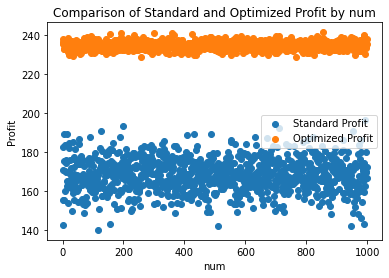

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(df_store2['num'], df_store2['sd_profit'], label='Standard Profit')
plt.scatter(df_store2['num'], df_store2['opti_profit'], label='Optimized Profit')
plt.xlabel('num')
plt.ylabel('Profit')
plt.title('Comparison of Standard and Optimized Profit by num')
plt.legend()
plt.show()


In [ ]:
import pandas as pd

# Assuming the DataFrame is named df
profit_diff = df_store2['opti_profit'] - df_store2['sd_profit']
avg_profit_diff = profit_diff.mean()

print("On average, opti_profit is ${:.2f} higher than sd_profit".format(avg_profit_diff))

On average, opti_profit is $66.23 higher than sd_profit


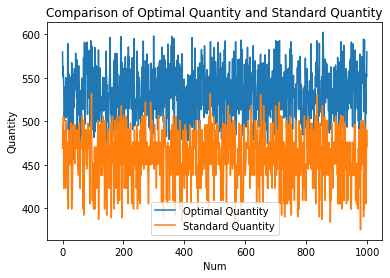

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

df_store2.plot(x='num', y='opti_quantity', label='Optimal Quantity', ax=ax)
df_store2.plot(x='num', y='sd_quantity', label='Standard Quantity', ax=ax)

ax.set_xlabel('Num')
ax.set_ylabel('Quantity')
ax.set_title('Comparison of Optimal Quantity and Standard Quantity')

plt.show()

____________